In [10]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
len(X), len(y)

(1000, 1000)

In [11]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [12]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


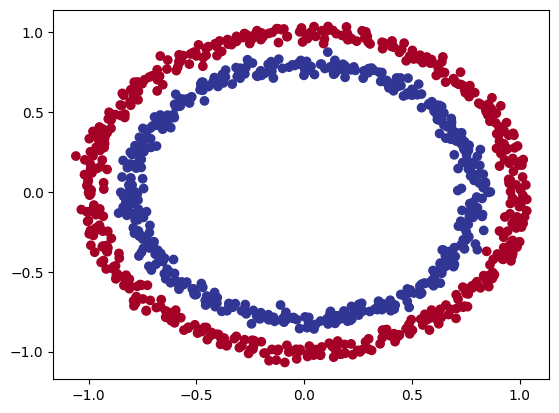

In [13]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [14]:
import torch
type(X)

numpy.ndarray

In [15]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [16]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [18]:
len(X_train), len(X_test)

(800, 200)

In [19]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [20]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [21]:
from sklearn import datasets

class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.two_linear_layers = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1))

  def forward(self, x):
    return self.two_linear_layers(x)


In [22]:
model_0 = CircleModel().to(device)
model_0

CircleModel(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [23]:
device

'cpu'

In [24]:
next(model_0.parameters()).device

device(type='cpu')

In [25]:
model_0.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.4761, -0.6020],
                      [ 0.5924,  0.3847],
                      [ 0.1467, -0.1321],
                      [-0.0378,  0.6838],
                      [ 0.2390, -0.3603]])),
             ('two_linear_layers.0.bias',
              tensor([-0.0374,  0.0600, -0.7044,  0.2192, -0.0148])),
             ('two_linear_layers.1.weight',
              tensor([[ 0.1941, -0.1452, -0.0942,  0.4162,  0.2498]])),
             ('two_linear_layers.1.bias', tensor([-0.1428]))])

In [26]:
untrained_preds = model_0(X_test.to(device))

In [27]:
print(f" len of prds {len(untrained_preds)}, shape {untrained_preds.shape}")
print(f" len of test {len(X_test)}, shape {untrained_preds.shape}")
print(f" 10 first preds: {untrained_preds[:10]}")
print(f" 10 first labels: {y_test[:10]}")

 len of prds 200, shape torch.Size([200, 1])
 len of test 200, shape torch.Size([200, 1])
 10 first preds: tensor([[ 0.0049],
        [ 0.0287],
        [-0.0414],
        [ 0.0179],
        [-0.0158],
        [-0.0014],
        [ 0.0453],
        [ 0.0383],
        [-0.0424],
        [ 0.0305]], grad_fn=<SliceBackward0>)
 10 first labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [28]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [29]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


In [30]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0049],
        [ 0.0287],
        [-0.0414],
        [ 0.0179],
        [-0.0158]])

In [31]:
y_pred_probs = torch.sigmoid(y_logits)
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 0., 1., 0.])

In [32]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

  if epoch % 10 == 0:
    print(f"epoch: {epoch} loss: {loss:.5f} Acc: {acc:.2f} test loss: {test_loss:.5f} test acc: {test_acc:.2f}%")

epoch: 0 loss: 0.69301 Acc: 50.38 test loss: 0.69439 test acc: 46.50%
epoch: 10 loss: 0.69300 Acc: 50.50 test loss: 0.69444 test acc: 46.00%
epoch: 20 loss: 0.69299 Acc: 51.00 test loss: 0.69449 test acc: 46.00%
epoch: 30 loss: 0.69299 Acc: 50.75 test loss: 0.69452 test acc: 46.00%
epoch: 40 loss: 0.69299 Acc: 51.00 test loss: 0.69455 test acc: 45.50%
epoch: 50 loss: 0.69299 Acc: 51.25 test loss: 0.69457 test acc: 46.50%
epoch: 60 loss: 0.69298 Acc: 51.25 test loss: 0.69459 test acc: 47.00%
epoch: 70 loss: 0.69298 Acc: 51.25 test loss: 0.69461 test acc: 46.50%
epoch: 80 loss: 0.69298 Acc: 51.50 test loss: 0.69462 test acc: 46.00%
epoch: 90 loss: 0.69298 Acc: 51.25 test loss: 0.69463 test acc: 46.00%


In [34]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("already exist")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

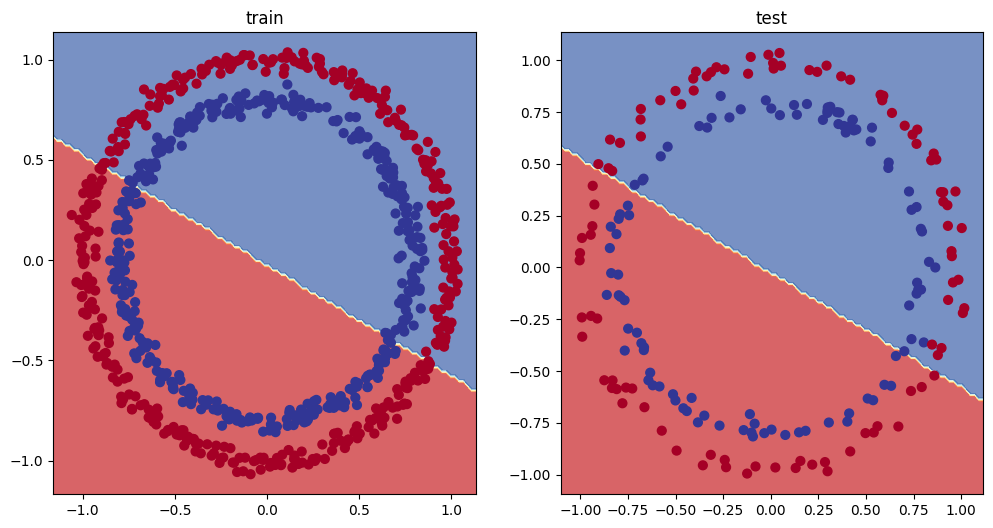

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

In [36]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV2().to(device)
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [37]:
loss_fn_2 = nn.BCEWithLogitsLoss()

optimizer_2 = torch.optim.SGD(params=model_1.parameters(),
                              lr=0.1)

In [38]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
model_1.train()

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn_2(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)

    if epoch%100 == 0:
      print(f"epoch: {epoch}  loss:  {loss:.5f}  acc: {acc:.2f} test loss: {test_loss:.5f} test acc: {test_acc:.2f}")


epoch: 0  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00
epoch: 100  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00
epoch: 200  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00
epoch: 300  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00
epoch: 400  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00
epoch: 500  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00
epoch: 600  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00
epoch: 700  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00
epoch: 800  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00
epoch: 900  loss:  0.69396  acc: 50.88 test loss: 0.69261 test acc: 51.00


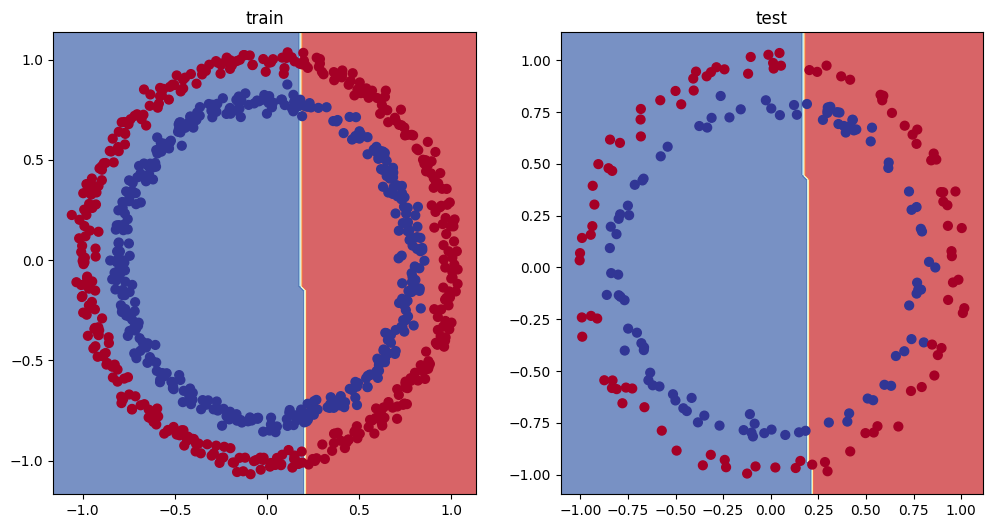

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_1, X_test, y_test)

In [40]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [41]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

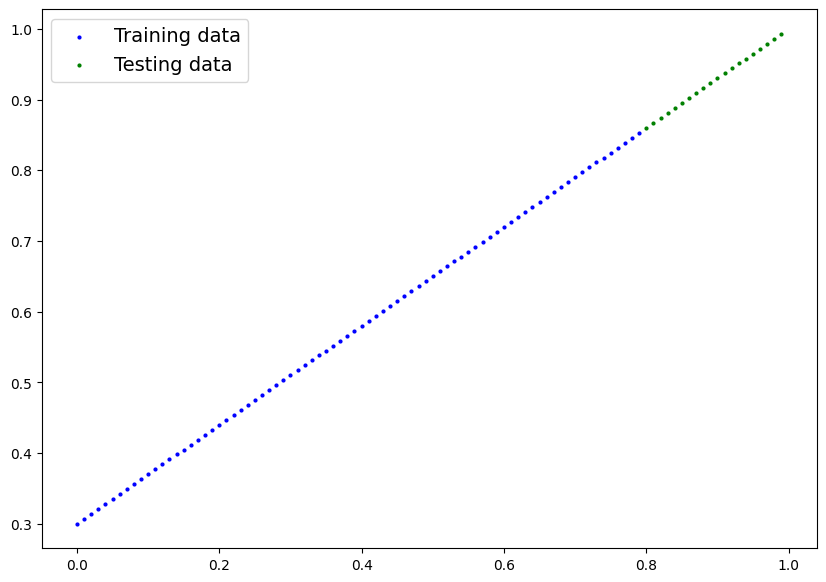

In [42]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [43]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
    ).to(device)


In [44]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [45]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"epoch: {epoch} loss: {loss:.5f}, test loss: {test_loss:.5f}")

epoch: 0 loss: 0.75986, test loss: 0.91103
epoch: 100 loss: 0.02858, test loss: 0.00081
epoch: 200 loss: 0.02533, test loss: 0.00209
epoch: 300 loss: 0.02137, test loss: 0.00305
epoch: 400 loss: 0.01964, test loss: 0.00341
epoch: 500 loss: 0.01940, test loss: 0.00387
epoch: 600 loss: 0.01903, test loss: 0.00379
epoch: 700 loss: 0.01878, test loss: 0.00381
epoch: 800 loss: 0.01840, test loss: 0.00329
epoch: 900 loss: 0.01798, test loss: 0.00360


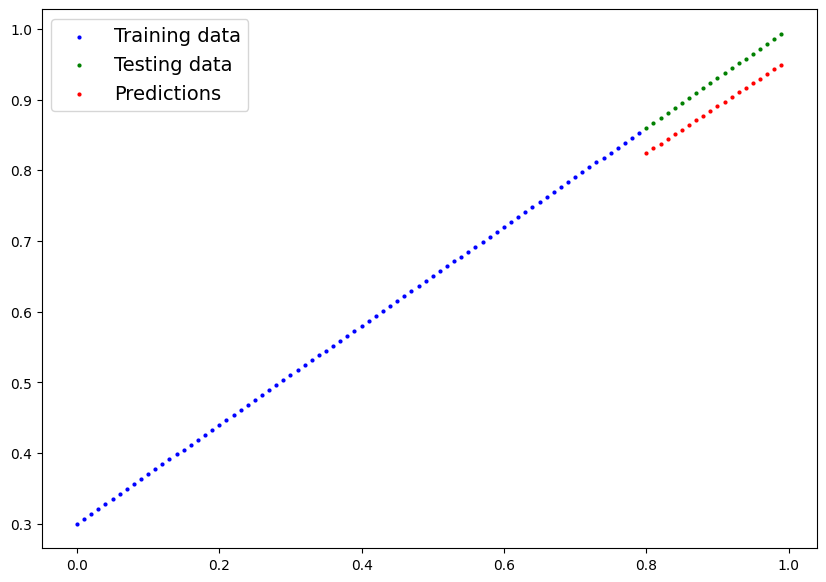

In [46]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions = y_preds.cpu())


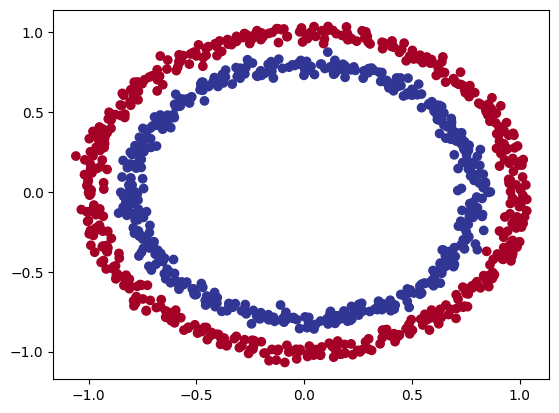

In [47]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [48]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [49]:
from torch import  nn
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=16)
    self.layer_2 = nn.Linear(in_features=16, out_features=16)
    self.layer_3 = nn.Linear(in_features=16, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [50]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [51]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch%100 == 0:
     print(f"epoch: {epoch}  loss:  {loss:.5f}  acc: {acc:.2f} test loss: {test_loss:.5f} test acc: {test_acc:.2f}")



epoch: 0  loss:  0.69753  acc: 50.00 test loss: 0.69784 test acc: 50.00
epoch: 100  loss:  0.68987  acc: 56.25 test loss: 0.69139 test acc: 51.50
epoch: 200  loss:  0.68663  acc: 52.88 test loss: 0.68875 test acc: 52.00
epoch: 300  loss:  0.68264  acc: 53.62 test loss: 0.68576 test acc: 52.50
epoch: 400  loss:  0.67735  acc: 54.00 test loss: 0.68189 test acc: 53.50
epoch: 500  loss:  0.67006  acc: 56.00 test loss: 0.67640 test acc: 55.50
epoch: 600  loss:  0.65938  acc: 62.38 test loss: 0.66777 test acc: 58.00
epoch: 700  loss:  0.64168  acc: 75.50 test loss: 0.65325 test acc: 68.50
epoch: 800  loss:  0.61284  acc: 87.38 test loss: 0.62886 test acc: 85.00
epoch: 900  loss:  0.56398  acc: 97.25 test loss: 0.58723 test acc: 93.00


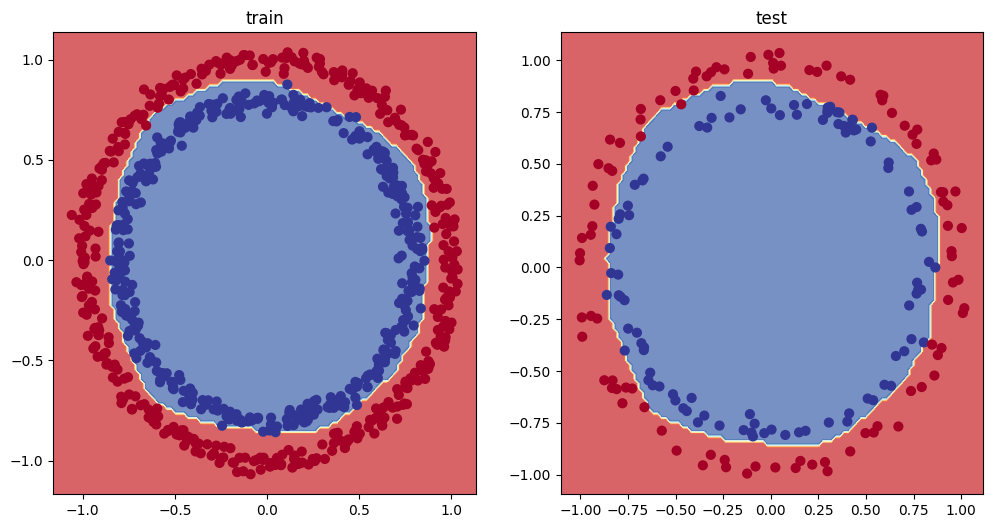

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_3, X_test, y_test)

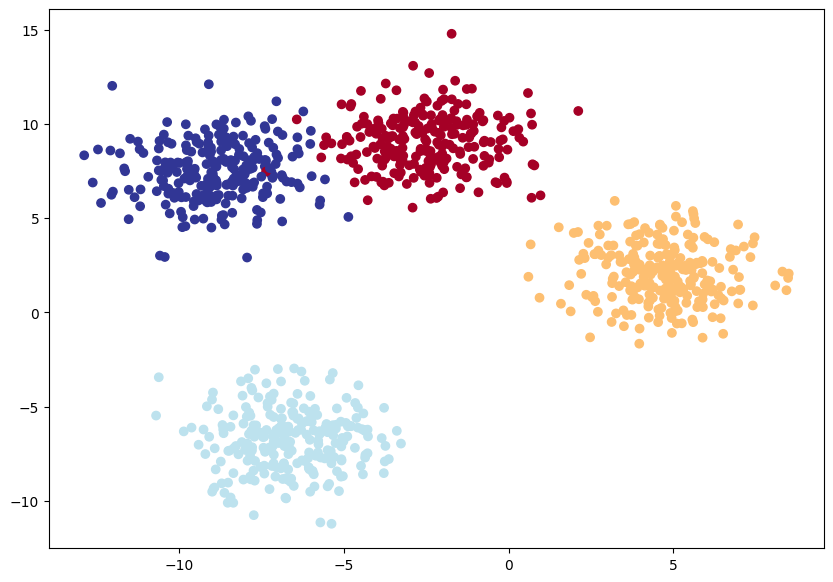

In [53]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


In [54]:
device = "cuda" if torch.cuda.is_available()  else "cpu"
device

'cpu'

In [55]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features))
  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [56]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [58]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test).to(device)

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [59]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:10])
y_logits[:10]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463],
        [0.3381, 0.1358, 0.1929, 0.3331],
        [0.2867, 0.1841, 0.2861, 0.2431],
        [0.3554, 0.1355, 0.1740, 0.3351],
        [0.3009, 0.1841, 0.2779, 0.2371],
        [0.3595, 0.1350, 0.1695, 0.3360]])


tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [60]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

  if epoch%10 == 0:
     print(f"epoch: {epoch}  loss:  {loss:.5f}  acc: {acc:.2f} test loss: {test_loss:.5f} test acc: {test_acc:.2f}")


epoch: 0  loss:  1.15883  acc: 40.38 test loss: 1.07554 test acc: 48.00
epoch: 10  loss:  0.64476  acc: 96.75 test loss: 0.66069 test acc: 97.50
epoch: 20  loss:  0.42535  acc: 98.50 test loss: 0.43074 test acc: 100.00
epoch: 30  loss:  0.25294  acc: 99.12 test loss: 0.24508 test acc: 99.50
epoch: 40  loss:  0.11232  acc: 99.25 test loss: 0.10229 test acc: 99.50
epoch: 50  loss:  0.06627  acc: 99.25 test loss: 0.05848 test acc: 99.50
epoch: 60  loss:  0.05068  acc: 99.25 test loss: 0.04293 test acc: 99.50
epoch: 70  loss:  0.04300  acc: 99.25 test loss: 0.03491 test acc: 99.50
epoch: 80  loss:  0.03836  acc: 99.25 test loss: 0.02988 test acc: 99.50
epoch: 90  loss:  0.03525  acc: 99.25 test loss: 0.02663 test acc: 99.50


In [62]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [63]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3437e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]])

In [64]:
y_pred = torch.argmax(y_pred_probs, dim=1)
y_pred[:10]


tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

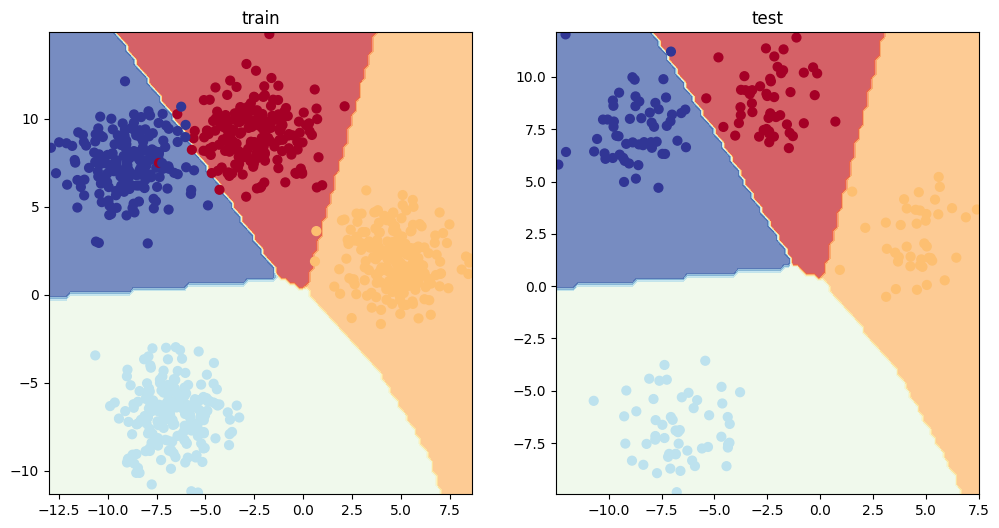

In [97]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [66]:
!pip install torchmetrics


In [100]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="binary").to(device)


In [69]:
import sklearn
from sklearn.datasets import make_moons

n_samples = 1000

X, y = make_moons(n_samples,
                    noise=0.03,
                    random_state=42)
len(X), len(y)


(1000, 1000)

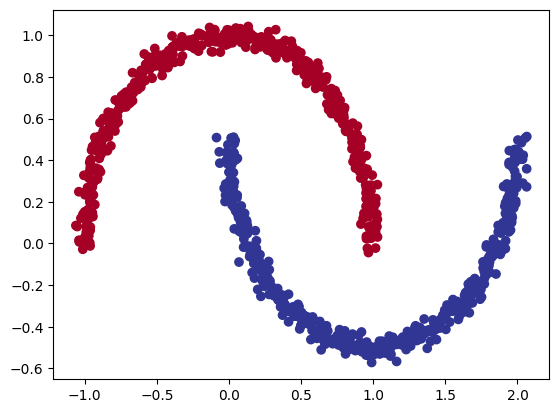

In [70]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [71]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)
X_train[:10], y_train[:10]

(tensor([[ 1.9758,  0.2076],
         [-0.9608,  0.4007],
         [-0.0986,  1.0231],
         [-0.1083,  0.9919],
         [ 0.3767, -0.2620],
         [-0.2237,  0.9529],
         [ 0.5371, -0.3586],
         [ 0.1013,  0.0867],
         [ 0.4661,  0.8945],
         [-0.9630,  0.2070]]),
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.]))

In [ ]:
HIDDEN_LAYERS = 16

In [81]:


class MoonModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=16):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

model_5 = MoonModel(input_features=2, output_features=1)
model_5.to(device)
model_5

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [85]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_5.parameters(),
                      lr=0.1)

In [102]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_5.train()

  train_logits = model_5(X_train).squeeze()
  train_preds = torch.round(torch.sigmoid(train_logits))

  loss = loss_fn(train_logits,
                 y_train)
  acc = torchmetric_accuracy(train_preds,
                             y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_5.eval()
  with torch.inference_mode():
    test_logits = model_5(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                 y_test)
    test_acc = torchmetric_accuracy(test_preds,
                                    y_test)

  if epoch%100==0:
    print(f"epoch: {epoch}  loss:  {loss:.5f}  acc: {acc:.2f} test loss: {test_loss:.5f} test acc: {test_acc:.2f}")



epoch: 0  loss:  0.00104  acc: 1.00 test loss: 0.00092 test acc: 1.00
epoch: 100  loss:  0.00101  acc: 1.00 test loss: 0.00088 test acc: 1.00
epoch: 200  loss:  0.00097  acc: 1.00 test loss: 0.00085 test acc: 1.00
epoch: 300  loss:  0.00094  acc: 1.00 test loss: 0.00083 test acc: 1.00
epoch: 400  loss:  0.00091  acc: 1.00 test loss: 0.00080 test acc: 1.00
epoch: 500  loss:  0.00088  acc: 1.00 test loss: 0.00077 test acc: 1.00
epoch: 600  loss:  0.00086  acc: 1.00 test loss: 0.00075 test acc: 1.00
epoch: 700  loss:  0.00083  acc: 1.00 test loss: 0.00073 test acc: 1.00
epoch: 800  loss:  0.00081  acc: 1.00 test loss: 0.00071 test acc: 1.00
epoch: 900  loss:  0.00078  acc: 1.00 test loss: 0.00069 test acc: 1.00


In [104]:
model_5.eval()
with torch.inference_mode():
  y_pred = model_5(X_test)

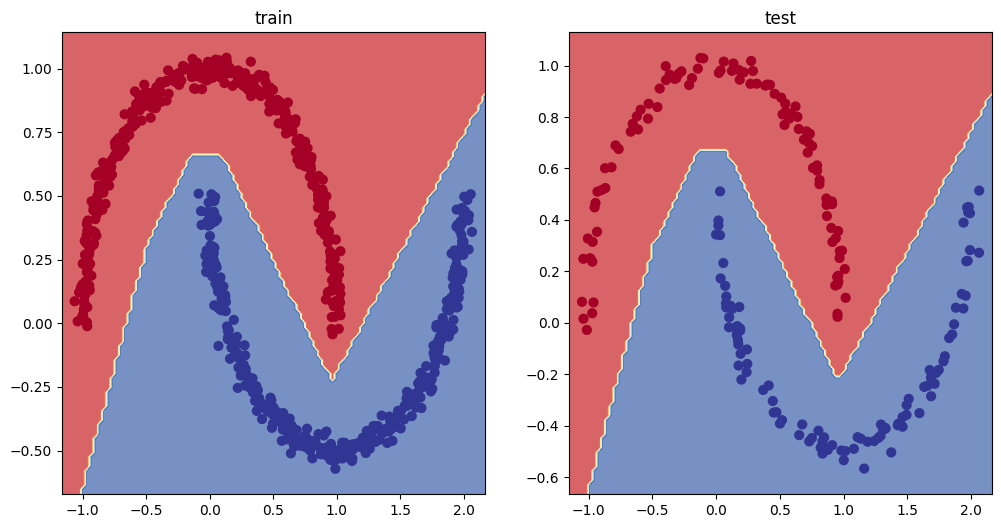

In [108]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_5, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_5, X_test, y_test)

In [109]:
def tanh(z):
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

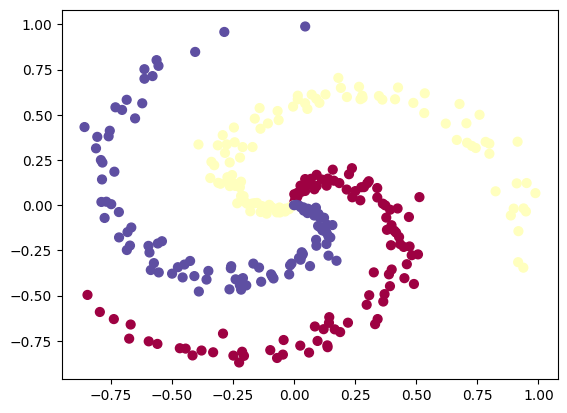

In [117]:
import numpy as np


N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [132]:
X.size
X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.LongTensor)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)
X_train[:10], y_train[:10]


<ipython-input-132-55b67a1a508c>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float)
<ipython-input-132-55b67a1a508c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).type(torch.LongTensor)


(tensor([[-0.0101, -0.3231],
         [ 0.3926, -0.4483],
         [ 0.0013,  0.0606],
         [ 0.7839,  0.3503],
         [ 0.5329,  0.5097],
         [ 0.2862,  0.0996],
         [ 0.1856,  0.1222],
         [-0.4074, -0.3924],
         [ 0.4616, -0.3269],
         [ 0.7992,  0.3404]]),
 tensor([2, 0, 0, 1, 1, 0, 0, 2, 0, 1]))

In [133]:
class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=16):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

model_6 = SpiralModel(input_features=2, output_features=3)
model_6.to(device)
model_6

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [134]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_6.parameters(),
                            lr=0.1)

In [136]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=3).to(device)


In [140]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(X_train.dtype)
epochs = 1000

for epoch in range(epochs):
  model_6.train()

  train_logits = model_6(X_train).squeeze()
  train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

  loss = loss_fn(train_logits,
                 y_train)
  acc = torchmetric_accuracy(train_preds,
                             y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_6.eval()
  with torch.inference_mode():
    test_logits = model_6(X_test).squeeze()
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,
                 y_test)
    test_acc = torchmetric_accuracy(test_preds,
                                    y_test)

  if epoch%100==0:
    print(f"epoch: {epoch}  loss:  {loss:.5f}  acc: {acc:.2f} test loss: {test_loss:.5f} test acc: {test_acc:.2f}")


torch.float32
epoch: 0  loss:  0.11494  acc: 0.96 test loss: 0.11000 test acc: 0.97
epoch: 100  loss:  0.10306  acc: 0.96 test loss: 0.09754 test acc: 0.97
epoch: 200  loss:  0.09676  acc: 0.96 test loss: 0.09069 test acc: 0.97
epoch: 300  loss:  0.08997  acc: 0.97 test loss: 0.08413 test acc: 0.97
epoch: 400  loss:  0.08472  acc: 0.97 test loss: 0.07882 test acc: 0.97
epoch: 500  loss:  0.07947  acc: 0.97 test loss: 0.07329 test acc: 0.97
epoch: 600  loss:  0.07537  acc: 0.97 test loss: 0.06889 test acc: 0.97
epoch: 700  loss:  0.07173  acc: 0.97 test loss: 0.06480 test acc: 0.97
epoch: 800  loss:  0.06777  acc: 0.97 test loss: 0.06081 test acc: 0.98
epoch: 900  loss:  0.06443  acc: 0.98 test loss: 0.05709 test acc: 0.98


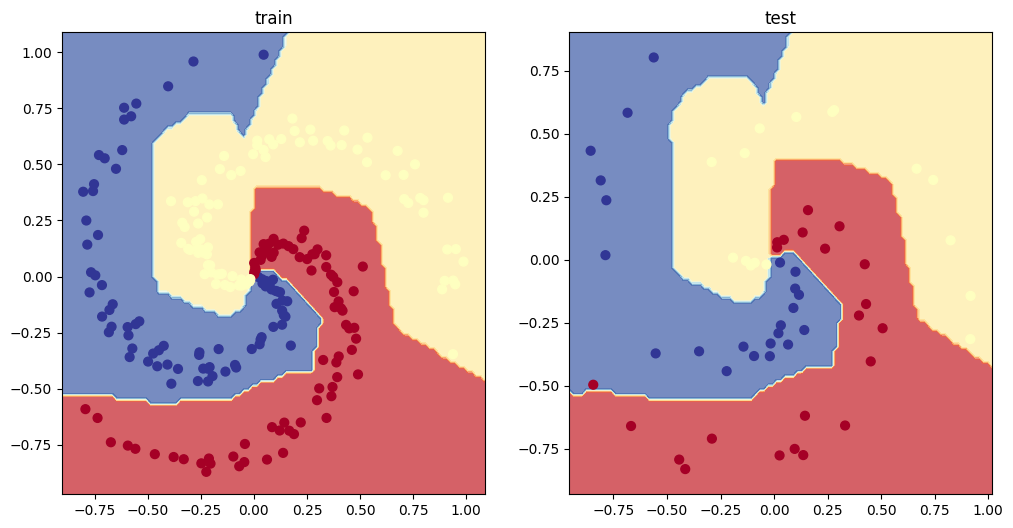

In [141]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_6, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_6, X_test, y_test)